<a href="https://colab.research.google.com/github/arkeodev/time-series/blob/main/Statistical_Time_Series_Analysis/09-residuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9. Residual Analysis Notebook

## 1 Imports and Data Creation

We’ll create a synthetic time series and then fit an AR(2) model for demonstration. The goal is to analyze residuals to check for issues like autocorrelation or non-normality.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# For reproducibility
np.random.seed(42)

# Generate synthetic AR(2) data:
# x_t = 0.5 + 0.6 x_{t-1} - 0.3 x_{t-2} + noise
n_samples = 200
errors = np.random.normal(0, 1, size=n_samples)
data = [0, 0]  # Start with two initial values

phi1, phi2 = 0.6, -0.3
C = 0.5

for t in range(2, n_samples):
    x_t = C + phi1 * data[t-1] + phi2 * data[t-2] + errors[t]
    data.append(x_t)

time_index = pd.date_range('2024-01-01', periods=n_samples, freq='D')
df_res = pd.DataFrame({'Date': time_index, 'Value': data})
df_res.set_index('Date', inplace=True)

## 2. Fit an AR(2) Model

In [2]:
model = AutoReg(df_res['Value'], lags=2, old_names=False)
results = model.fit()
print(results.summary())

                            AutoReg Model Results                             
Dep. Variable:                  Value   No. Observations:                  200
Model:                     AutoReg(2)   Log Likelihood                -266.498
Method:               Conditional MLE   S.D. of innovations              0.930
Date:                Thu, 02 Jan 2025   AIC                            540.995
Time:                        16:19:16   BIC                            554.148
Sample:                    01-03-2024   HQIC                           546.319
                         - 07-18-2024                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5097      0.081      6.279      0.000       0.351       0.669
Value.L1       0.5629      0.067      8.413      0.000       0.432       0.694
Value.L2      -0.3434      0.067     -5.136      0.0

/Users/kenanagyel/anaconda3/envs/pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


## 3. Obtain Residuals

In [3]:
residuals = results.resid
df_res['Residuals'] = residuals
df_res.head()

,Value,Residuals
Date,,
2024-01-01,0.000000,NaN
2024-01-02,0.000000,NaN
2024-01-03,1.147689,0.638016
2024-01-04,2.711643,1.555892
2024-01-05,1.548526,-0.093535


## 4. Residual Plots and Analysis

### 4.1 Residual Plot (Time Series)

A quick visual check for obvious patterns or trends in the residuals.

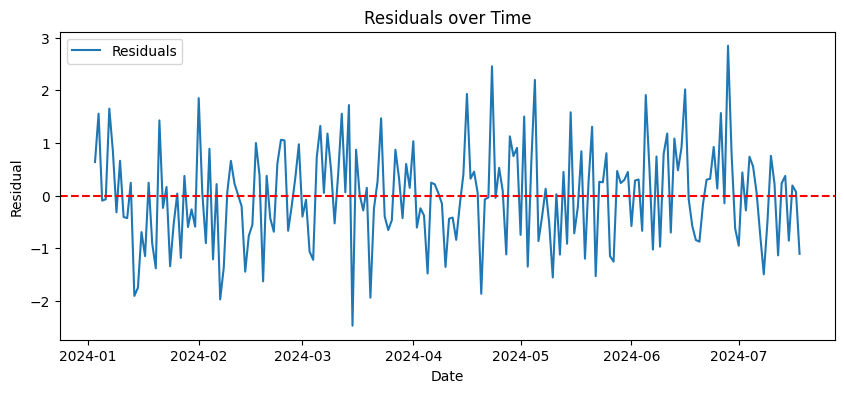

In [4]:
plt.figure(figsize=(10, 4))
plt.plot(df_res.index, df_res['Residuals'], label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals over Time")
plt.ylabel("Residual")
plt.xlabel("Date")
plt.legend()
plt.show()

**Interpretation**: Ideally, residuals should appear as **white noise**, centered around zero with no visible pattern.

### 4.2 Histogram and Q-Q Plot

Check if residuals are approximately normally distributed.

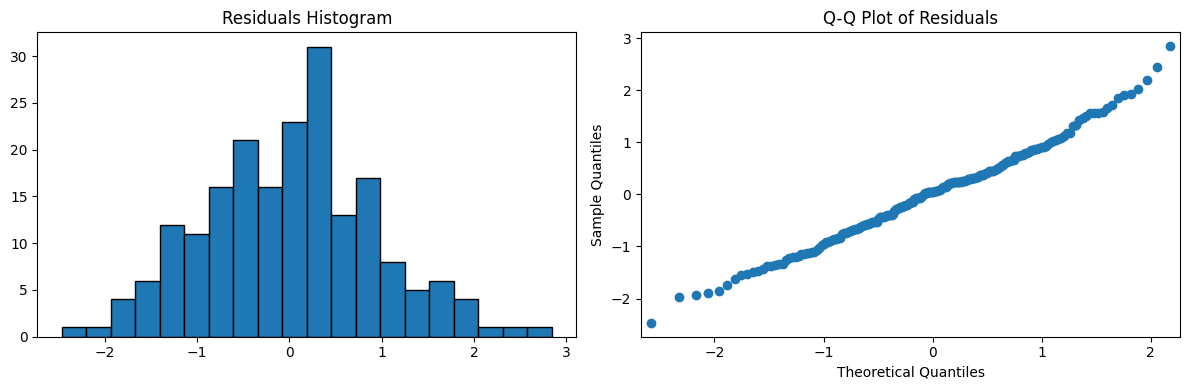

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(df_res['Residuals'], bins=20, edgecolor='k')
axes[0].set_title("Residuals Histogram")

# Q-Q Plot
sm.qqplot(df_res['Residuals'], line='s', ax=axes[1])
axes[1].set_title("Q-Q Plot of Residuals")

plt.tight_layout()
plt.show()

**Interpretation**:
- **Histogram**: Should look roughly bell-shaped if normal.  
- **Q-Q Plot**: Points should lie close to the line if the residuals are normally distributed.

### 4.3 Autocorrelation Check (ACF/PACF)

Residuals ideally exhibit **no** significant autocorrelation; large spikes might indicate leftover structure the model didn’t capture.

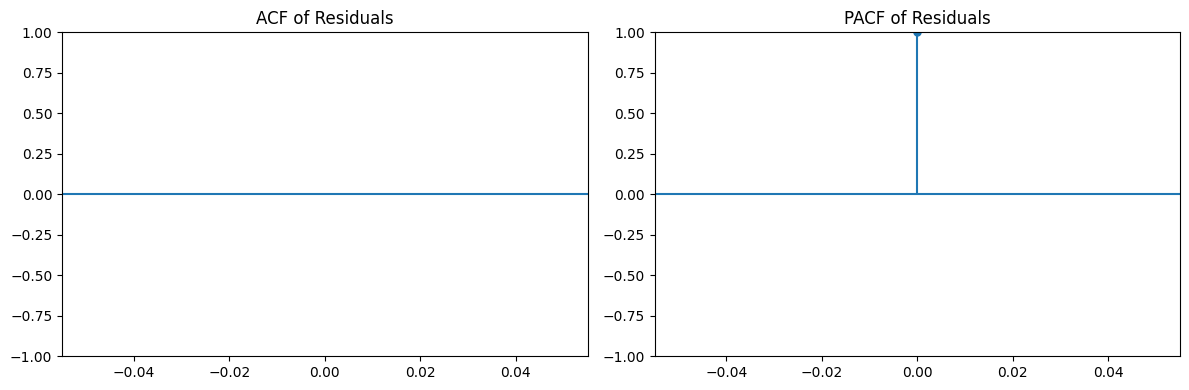

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(df_res['Residuals'], ax=axes[0], lags=20, title="ACF of Residuals")
plot_pacf(df_res['Residuals'], ax=axes[1], lags=20, title="PACF of Residuals")

plt.tight_layout()
plt.show()

**Interpretation**:
- Large significant lags in the ACF/PACF plots imply the residuals are **not** white noise, suggesting that the model might be improved by adding more lags or different terms (e.g., seasonality).

### 4.4 Summary Statistics

Finally, we can compute basic statistics (mean, variance, etc.):

In [7]:
print("Residuals Summary Statistics:")
print(df_res['Residuals'].describe())

Residuals Summary Statistics:
count    1.980000e+02
mean     1.121437e-16
std      9.319652e-01
min     -2.467621e+00
25%     -6.449907e-01
50%      5.058728e-02
75%      5.568908e-01
max      2.844655e+00
Name: Residuals, dtype: float64


- We look to see if the **mean** is close to 0.  
- Check if there is excessive **skewness** or **kurtosis**.

## 5 Conclusion

Residual analysis is crucial for **validating** time series models. If the residuals show patterns, autocorrelation, or non-normal distributions (when normality is assumed), you may need to:
- Adjust the model order (AR, MA components).
- Include trend/seasonality adjustments.
- Revisit transformations or additional features.